In [1]:
# Code is adapted from https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630

import os
import re
from io import StringIO

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords


from markdown import Markdown
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances

# importing networkx
import networkx as nx

# importing matplotlib.pyplot
import matplotlib.pyplot as plt

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/malcolm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read file in foam workspace and convert to pandas

In [2]:

# Patch markdown to remove markdown elements.
def unmark_element(element, stream=None):
    if stream is None:
        stream = StringIO()
    if element.text:
        # Remove wikilinks
        element.text = element.text.replace("[[", "")
        element.text = element.text.replace("]]", "")
        stream.write(element.text)
    for sub in element:
        unmark_element(sub, stream)
    if element.tail:
        stream.write(element.tail)
    return stream.getvalue()


# patching Markdown
Markdown.output_formats["plain"] = unmark_element
__md = Markdown(output_format="plain")
__md.stripTopLevelTags = False

# Sample corpus
documents = []

path = r"../data"
for root, directories, files in os.walk(path):
    for file in files:
        if file.endswith(".md"):
            with open(os.path.join(root, file), "r") as f:
                documents.append(__md.convert(f.read()))

documents_df = pd.DataFrame(documents, columns=["documents"])


Calculate similarities with if-idf

In [3]:
# removing special characters and stop words from the text
stop_words_l = stopwords.words("english")
documents_df["documents_cleaned"] = documents_df.documents.apply(
    lambda x: " ".join(
        re.sub(r"[^a-zA-Z]", " ", w).lower()
        for w in x.split()
        if re.sub(r"[^a-zA-Z]", " ", w).lower() not in stop_words_l
    )
)

tfidfvectoriser = TfidfVectorizer()
tfidfvectoriser.fit(documents_df.documents_cleaned)
tfidf_vectors = tfidfvectoriser.transform(documents_df.documents_cleaned)

pairwise_similarities = np.dot(tfidf_vectors, tfidf_vectors.T).toarray()
pairwise_differences = euclidean_distances(tfidf_vectors)


def most_similar(
    doc_id: int, similarity_matrix: np.ndarray, matrix: str = "Cosine Similarity"
) -> np.ndarray:
    """Get the most similar text in a corpus

    Args:
        doc_id (int): index of original text
        similarity_matrix (np.ndarray): Text similarity matrix
        matrix (str, optional): type of similarity measure. Defaults to "Cosine Similarity".

    Returns:
        np.ndarray: list of index of closest text sorted.
    """
    if matrix == "Euclidean Distance":
        similar_ix = np.argsort(similarity_matrix[doc_id])
    else:
        similar_ix = np.argsort(similarity_matrix[doc_id])[::-1]
    return similar_ix


closest = most_similar(0, pairwise_similarities, "Cosine Similarity")
# We skip 0 because it is the document itself.
print(f'Document: {documents_df.iloc[closest[1]]["documents"]}')

print(most_similar(0, pairwise_differences, "Euclidean Distance"))


Document: SMART
SMART stands for Specific, Measurable, Attainable, Relevant, Time-oriented.
[0 5 4 2 6 1 3]


Print results in a graph

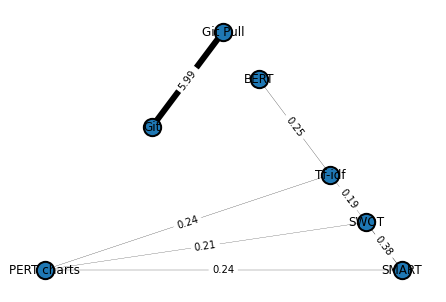

In [4]:
g = nx.Graph()


def rgb_to_hex(rgb):
    return "#%02x%02x%02x" % rgb


for i in range(len(documents)):
    closest = most_similar(i, pairwise_similarities, "Cosine Similarity")
    for el in closest:
        if pairwise_similarities[i][el] > 0 and i != el:
            g.add_edge(
                documents[i].partition("\n")[0],
                documents[el].partition("\n")[0],
                weight=round(pairwise_similarities[i][el] * 1000) / 100,
            )

weights = nx.get_edge_attributes(g, "weight").values()

pos = nx.planar_layout(g)

nx.draw(
    g,
    pos,
    with_labels=True,
    width=list(weights),
    edgecolors="black",
    linewidths=2,
    connectionstyle="arc3,rad=0.15",
)

nx.draw_networkx_edge_labels(
    g,
    pos,
    nx.get_edge_attributes(g, "weight"),
)
plt.savefig("it-idf_results.png")
